In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load the training data

Train_Path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
Train_Data = pd.read_csv(Train_Path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
Train_Data.head(5)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
# Load the test data

Test_Path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
Test_Data = pd.read_csv(Test_Path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
Test_Data.head(5)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [5]:
#Load test solution

Test_sol_Path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt"
Test_sol_Data = pd.read_csv(Test_sol_Path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
Test_sol_Data.drop(Test_sol_Data.columns[[0, 2]], axis=1, inplace=True)
Test_sol_Data.rename(columns = {'Title':'Original Genre'}, inplace = True) 
Test_sol_Data.head(5)

,Original Genre
1,thriller
2,comedy
3,documentary
4,drama
5,drama


In [6]:
#Count each genre value
Train_Data.Genre.value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

Text(0, 0.5, 'Distribution of Genres')

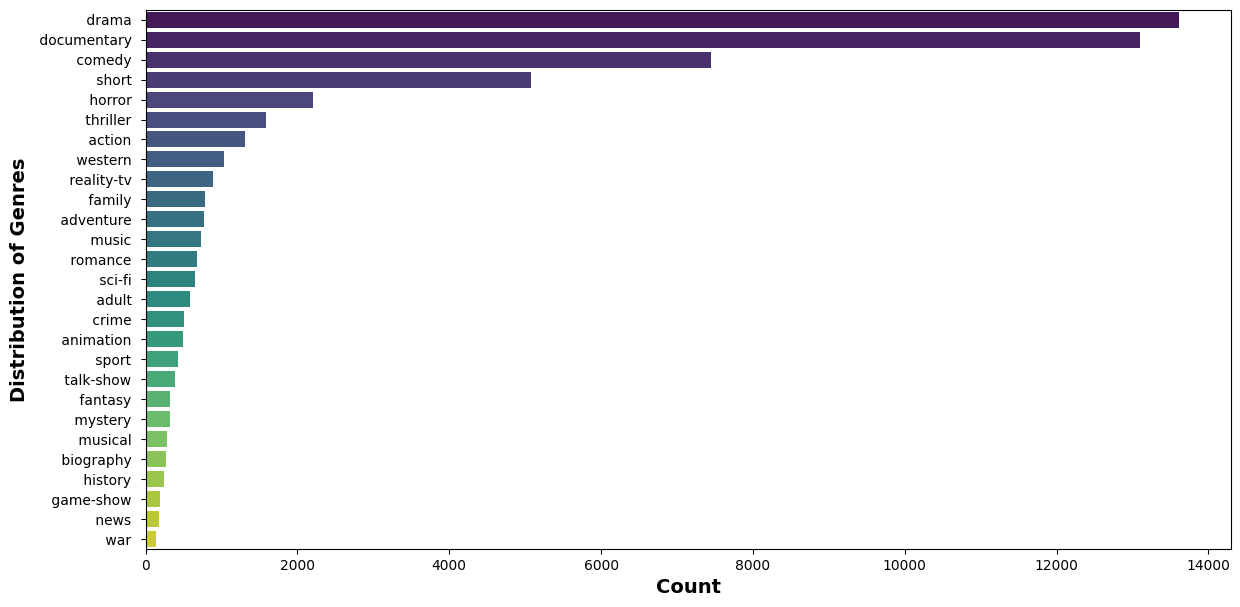

In [7]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=Train_Data, y='Genre', order=Train_Data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Distribution of Genres', fontsize=14, fontweight='bold')

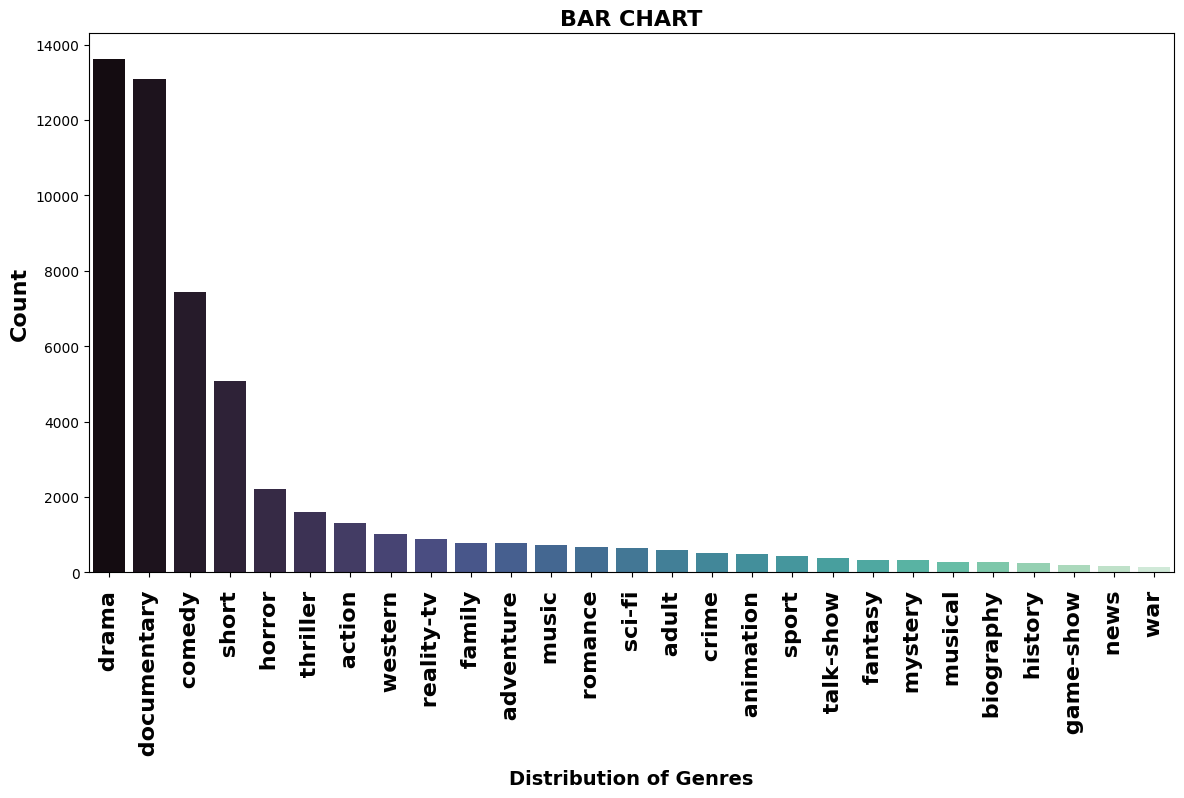

In [8]:
# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = Train_Data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='mako')
plt.xlabel('Distribution of Genres', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')
plt.title('BAR CHART', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=16, fontweight='bold')
plt.show()

In [9]:
# Data Processing

Train_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [10]:
#Find any null value
Train_Data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [11]:
# Initialize the stemmer and stop words
Stemmer = LancasterStemmer()
Stop_Words = set(stopwords.words('english'))

# Define the clean_text function
def clean(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
Train_Data['Cleaning'] = Train_Data['Description'].apply(clean)
Test_Data['Cleaning'] = Test_Data['Description'].apply(clean)

In [12]:
# Droping the redundant data
print("shape before drop nulls",Train_Data.shape)
Train_Data = Train_Data.drop_duplicates()
print("shape after drop nulls",Train_Data.shape)

shape before drop nulls (54214, 4)
shape after drop nulls (54214, 4)


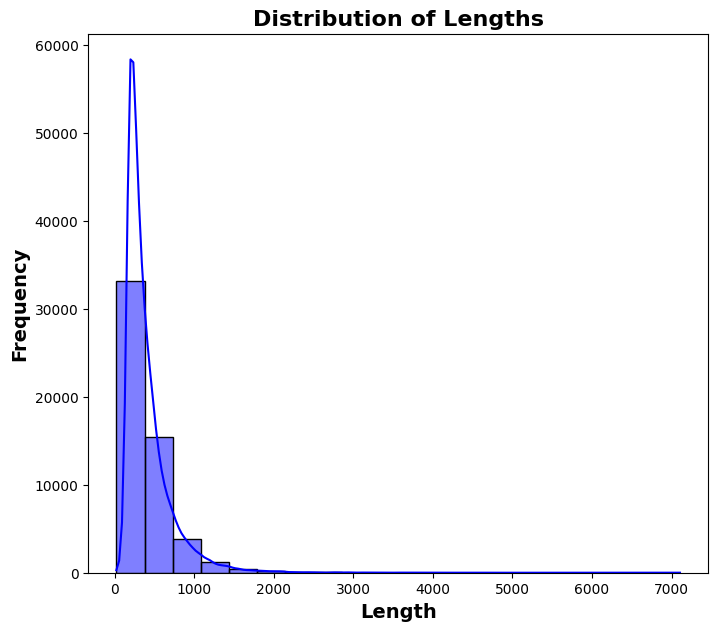

In [13]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Calculate the length of cleaned text
Train_Data['length_Text_cleaning'] = Train_Data['Cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=Train_Data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

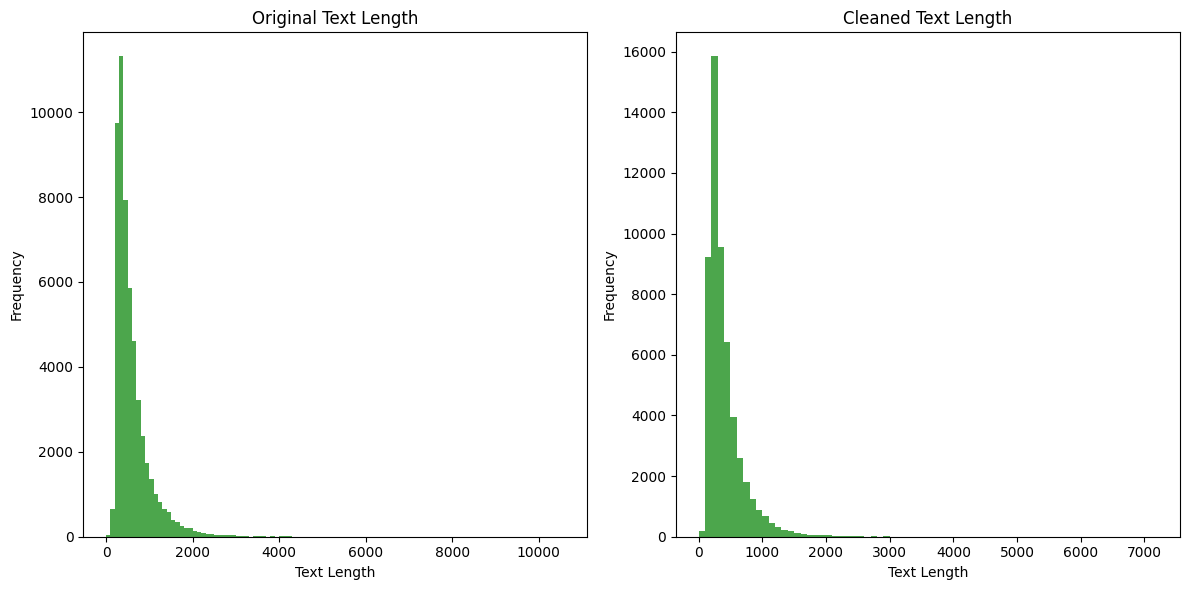

In [14]:
# Create histograms to visualize the distribution of text lengths before and after cleaning

# Set up the figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = Train_Data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Subplot 2: Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = Train_Data['Cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [15]:
# Text Vectorization (TF-IDF)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(Train_Data['Cleaning'])

# Transform the test data
X_test = vectorizer.transform(Test_Data['Cleaning'])

In [16]:
# Split the data into training and validation sets
X = X_train
y = Train_Data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Initialize and train a Multinomial Naive Bayes Classifier
NB = MultinomialNB()
NB.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = NB.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.4444341971779028
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       247
       adult        0.00      0.00      0.00       137
   adventure        0.00      0.00      0.00       143
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        49
      comedy        0.62      0.03      0.06      1496
       crime        0.00      0.00      0.00       108
 documentary        0.54      0.89      0.67      2624
       drama        0.38      0.88      0.53      2744
      family        0.00      0.00      0.00       181
     fantasy        0.00      0.00      0.00        64
   game-show        0.00      0.00      0.00        34
     history        0.00      0.00      0.00        51
      horror        0.00      0.00      0.00       409
       music        0.00      0.00      0.00       154
     musical        0.00      0.00      0.00        59
     mystery        0.00

In [18]:
accuracy_NB = accuracy_score(y_val, y_pred)
accuracy_NB

0.4444341971779028

In [19]:
# Initialize and train a Logistic Regression Classifier
logreg = LogisticRegression(multi_class='multinomial', solver='sag')
logreg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = logreg.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5840634510744259
               precision    recall  f1-score   support

      action        0.52      0.24      0.33       247
       adult        0.85      0.20      0.33       137
   adventure        0.58      0.13      0.21       143
   animation        0.60      0.03      0.06       104
   biography        0.00      0.00      0.00        49
      comedy        0.54      0.57      0.55      1496
       crime        0.00      0.00      0.00       108
 documentary        0.66      0.88      0.75      2624
       drama        0.53      0.81      0.64      2744
      family        0.64      0.05      0.09       181
     fantasy        0.00      0.00      0.00        64
   game-show        0.88      0.44      0.59        34
     history        0.00      0.00      0.00        51
      horror        0.69      0.56      0.62       409
       music        0.71      0.36      0.48       154
     musical        0.00      0.00      0.00        59
     mystery        0.00

In [20]:
accuracy_logreg = accuracy_score(y_val, y_pred)
accuracy_logreg

0.5840634510744259

In [21]:
# Use the trained model to make predictions on the test data
X_test_predictions = NB.predict(X_test)
Test_Data['Predicted_Genre_NB'] = X_test_predictions

In [22]:
# Use the trained model to make predictions on the test data
X_test_predictions = logreg.predict(X_test)
Test_Data['Predicted_Genre_LR'] = X_test_predictions

In [23]:
# Save the test_data DataFrame with predicted genres to a CSV file
Test_Data.to_csv('predicted_genres.csv', index=False)

# Add actual genre column to predicted dataFrame
extracted_col = Test_sol_Data["Original Genre"]
Test_Data.insert(5, "Original Genre", extracted_col)

In [24]:
# Display the 'test_data' DataFrame with predicted and actual genres
Test_Data.head()

,Id,Title,Description,Cleaning,Predicted_Genre_NB,Original Genre,Predicted_Genre_LR
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama,NaN,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama,thriller,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary,comedy,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama,documentary,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama,drama,drama


In [25]:
count_same_values_NB = (Test_Data['Predicted_Genre_NB'] == Test_Data['Original Genre']).sum()
count_same_values_LR = (Test_Data['Predicted_Genre_LR'] == Test_Data['Original Genre']).sum()

print("Number of samples where Naive Bayes Classifier predicted accurately:", count_same_values_NB)
print("Number of samples where Logistic Regression Classifier predicted accurately:", count_same_values_LR)

Number of samples where Naive Bayes Classifier predicted accurately: 13326
Number of samples where Logistic Regression Classifier predicted accurately: 10908


In [26]:
sum = accuracy_NB + accuracy_logreg
size1 = (accuracy_NB/sum)
size2 = (accuracy_logreg/sum)

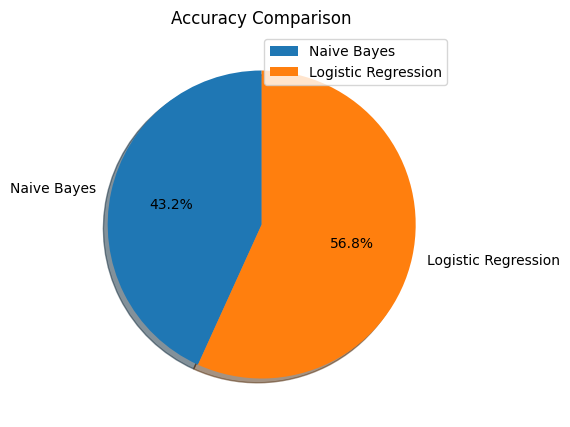

In [27]:
labels = ['Naive Bayes', 'Logistic Regression']
sizes = [size1, size2]

# Plotting the pie chart
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow = True)
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

In [28]:
# On the Basis of Solution

sum = count_same_values_NB + count_same_values_LR
portion1 = (count_same_values_NB/sum)
portion2 = (count_same_values_LR/sum)

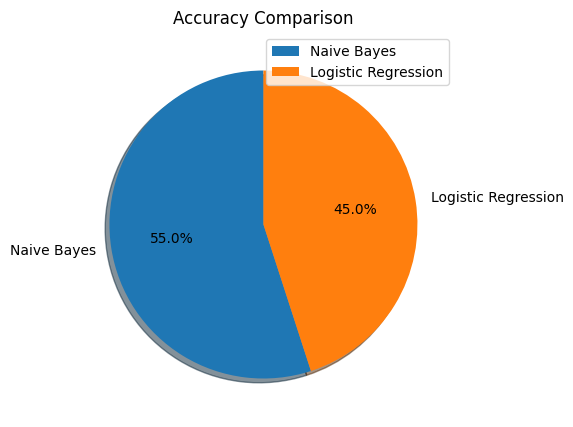

In [29]:
labels = ['Naive Bayes', 'Logistic Regression']
sizes = [portion1, portion2]

# Plotting the pie chart
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow = True)
plt.title('Accuracy Comparison')
plt.legend()
plt.show()